In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from scipy import stats

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score,plot_confusion_matrix, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
import graphviz
from dmba import classificationSummary
import itertools
pd.set_option('display.max_columns', None)

In [3]:
def plot_confusion_matrix_2(cm, 
                          normalize=False,
                          title='Confusion matrix',
                          #cmap=sns.diverging_palette(220,10,as_cmap=True)):
                          cmap = 'Greys'):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Non competitive","Competitive"], rotation=45)
    plt.yticks(tick_marks , ["Non competitive","Competitive"])

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
%matplotlib inline

In [6]:
pd.set_option('display.max_rows', None)

In [7]:
df = pd.read_excel("ebayAuctions.xlsx", sheet_name='eBay auctions')

# 1) Data Preprocessing:  
- Create dummy variables for the categorical predictors. 
- These include Category (18 categories), Currency (USD, GBP, Euro), EndDay (Monday–Sunday), and Duration (1, 3, 5, 7, or 10 days). 
- Perform any other preprocessing steps that you might consider to be necessary and explain briefly. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


## a) Looking for outliers

In [9]:
df_dtypes = df.dtypes.reset_index()

Feature: sellerRating


<AxesSubplot:xlabel='sellerRating'>

Feature: Duration


<AxesSubplot:xlabel='Duration'>

Feature: ClosePrice


<AxesSubplot:xlabel='ClosePrice'>

Feature: OpenPrice


<AxesSubplot:xlabel='OpenPrice'>

Feature: Competitive?


<AxesSubplot:xlabel='Competitive?'>

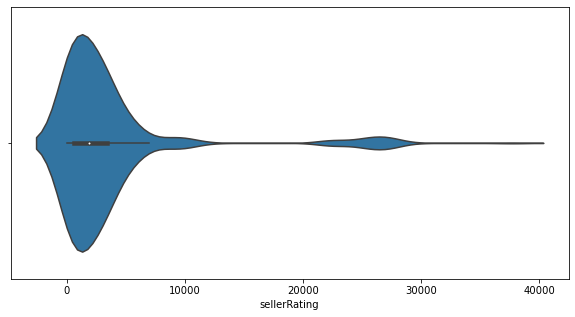

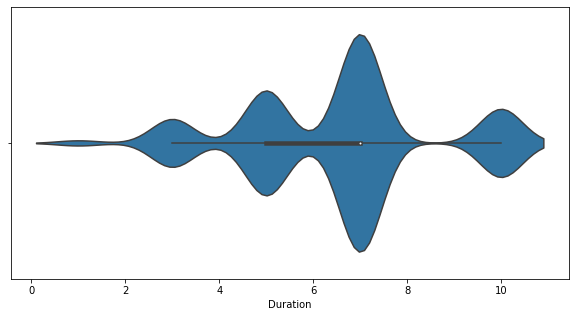

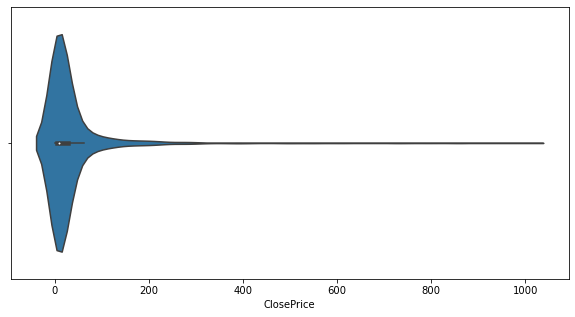

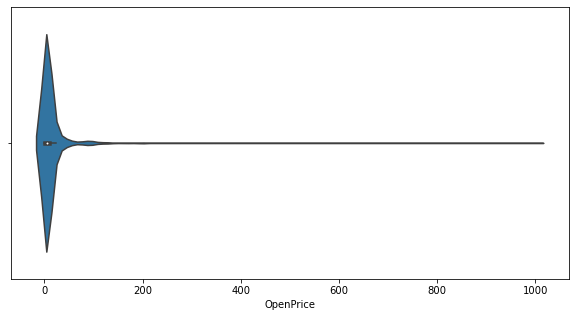

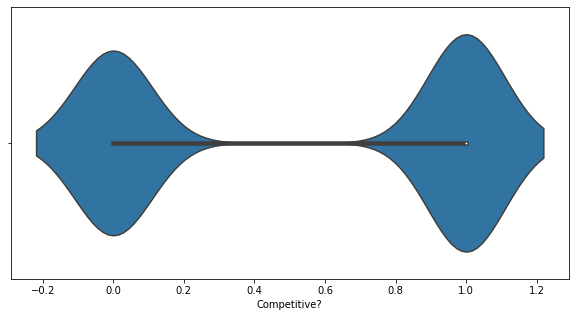

In [10]:
for feat in df[df_dtypes[df_dtypes[0]!="object"]["index"]]:
    print(f"Feature: {feat}")
    plt.figure(figsize = (10,5))
    plt.xlabel(feat)
    plt.xticks()
    display(sns.violinplot(x = feat, data = df))

In [11]:
df.shape

(1972, 8)

In [12]:
#Elimianitng outliers
outlier_col = df[["OpenPrice"]]
df= df[(np.abs(stats.zscore(outlier_col)) <= 3).all(axis=1)]

In [13]:
df.shape

(1951, 8)

## b) Data transformation (ordinal variables, dummy variables)

In [14]:
values_sets = set()
for feat in df[df_dtypes[df_dtypes[0]=="object"]["index"]]:
    print(f"Feature: {feat}")
    print(df[feat].unique())
    print(" ")

Feature: Category
['Music/Movie/Game' 'Automotive' 'SportingGoods' 'Home/Garden' 'Books'
 'Collectibles' 'Business/Industrial' 'Toys/Hobbies' 'Electronics'
 'Computer' 'EverythingElse' 'Clothing/Accessories' 'Coins/Stamps'
 'Antique/Art/Craft' 'Jewelry' 'Pottery/Glass' 'Health/Beauty'
 'Photography']
 
Feature: Currency
['US' 'GBP' 'EUR']
 
Feature: endDay
['Mon' 'Tue' 'Fri' 'Thu' 'Sat' 'Sun' 'Wed']
 


In [15]:
category_pp = df["Category"].value_counts(normalize = True).reset_index()

In [16]:
category_pp["Category %"] = category_pp["Category"].cumsum()

In [17]:
category_pp

,index,Category,Category %
0,Music/Movie/Game,0.206561,0.206561
1,Collectibles,0.121476,0.328037
2,Toys/Hobbies,0.119938,0.447975
3,Antique/Art/Craft,0.090210,0.538186
4,Automotive,0.085597,0.623783
5,SportingGoods,0.063045,0.686827
6,Clothing/Accessories,0.060994,0.747822
7,Home/Garden,0.052281,0.800103
8,Jewelry,0.042030,0.842132
9,Health/Beauty,0.032804,0.874936


In [18]:
categories_to_keep = category_pp[category_pp["Category %"]<0.81]["index"].tolist()

In [19]:
#df.loc[~(df["Category"].isin(categories_to_keep)), "Category"] = "Other"

In [20]:
df["Category"].value_counts(normalize = True)

Music/Movie/Game        0.206561
Collectibles            0.121476
Toys/Hobbies            0.119938
Antique/Art/Craft       0.090210
Automotive              0.085597
SportingGoods           0.063045
Clothing/Accessories    0.060994
Home/Garden             0.052281
Jewelry                 0.042030
Health/Beauty           0.032804
Books                   0.027678
Electronics             0.027678
Computer                0.017940
Coins/Stamps            0.017427
Pottery/Glass           0.009739
Business/Industrial     0.009226
EverythingElse          0.008713
Photography             0.006663
Name: Category, dtype: float64

In [21]:
df["Weekday"] = np.where(df["endDay"].isin(['Mon','Tue','Wed','Thu']), 1, 0)

In [22]:
df = pd.concat([df, pd.get_dummies(df["Category"],prefix="Category")], axis = 1)

In [23]:
del df["Category"]

In [24]:
df = pd.concat([df, pd.get_dummies(df["Currency"],prefix="Currency")], axis = 1)

In [25]:
del df["Currency"]

In [26]:
df = pd.concat([df, pd.get_dummies(df["endDay"],prefix="endDay")], axis = 1)

In [27]:
del df["endDay"]

In [28]:
df = pd.concat([df, pd.get_dummies(df["Duration"].astype(str),prefix="Duration")], axis = 1)

In [29]:
del df["Duration"]

# 2) Split the data into training and test datasets using a 60%:40% ratio. 

In [30]:
seed = 42

In [31]:
X = df.drop("Competitive?", axis = 1).values
y = df["Competitive?"].values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = seed)

 # 3) Fit a classification tree using all predictors (if feasible). To avoid overfitting, set the minimum number of records in a terminal node to 50. Write down the results in terms of rules.  

In [33]:
fullClassTree = DecisionTreeClassifier(random_state=seed, min_samples_leaf=50)

In [34]:
fullClassTree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=50, random_state=42)

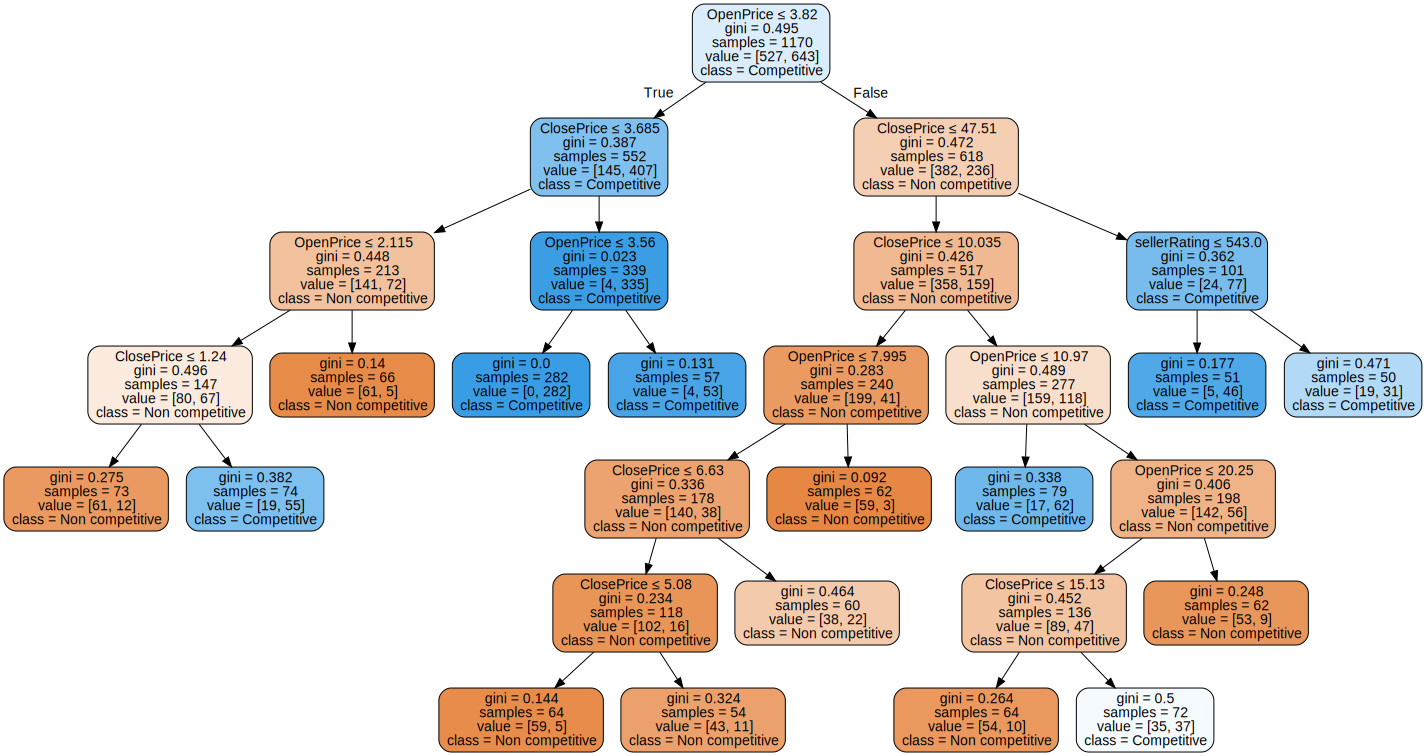

In [35]:
dot_data = export_graphviz(fullClassTree, 
                  feature_names=df.drop("Competitive?", axis = 1).columns.tolist(),  
                  class_names=["Non competitive", "Competitive"],  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph

In [36]:
tree_rules = export_text(fullClassTree, feature_names=list(df.drop("Competitive?", axis = 1)))

In [37]:
print(tree_rules)

|--- OpenPrice <= 3.82
|   |--- ClosePrice <= 3.69
|   |   |--- OpenPrice <= 2.12
|   |   |   |--- ClosePrice <= 1.24
|   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  1.24
|   |   |   |   |--- class: 1
|   |   |--- OpenPrice >  2.12
|   |   |   |--- class: 0
|   |--- ClosePrice >  3.69
|   |   |--- OpenPrice <= 3.56
|   |   |   |--- class: 1
|   |   |--- OpenPrice >  3.56
|   |   |   |--- class: 1
|--- OpenPrice >  3.82
|   |--- ClosePrice <= 47.51
|   |   |--- ClosePrice <= 10.03
|   |   |   |--- OpenPrice <= 7.99
|   |   |   |   |--- ClosePrice <= 6.63
|   |   |   |   |   |--- ClosePrice <= 5.08
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- ClosePrice >  5.08
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- ClosePrice >  6.63
|   |   |   |   |   |--- class: 0
|   |   |   |--- OpenPrice >  7.99
|   |   |   |   |--- class: 0
|   |   |--- ClosePrice >  10.03
|   |   |   |--- OpenPrice <= 10.97
|   |   |   |   |--- class: 1
|   |   |   |--- OpenPric

# 4) Describe the interesting/unexpected and uninteresting (= rather obvious) information that these rules provide. 

The decision tree classifier does not seem to be generating very intuitive or useful rules. 
Nevertheless, overall, it seems that orders with a lower OpenPrice and a higher ClosePrice are more likely to be competitive.

# 5) Suppose you had to slightly reduce the number of predictors due to software limitations, or for clarity of presentation, which would be (a) good variable(s) to choose? 

In [38]:
#These are predictors that the seller can control or aim to control
final_columns = []
for col in df.columns:
    for important_col in ['Duration', 'OpenPrice','Weekday', 'endDay','Category', 'Currency','sellerRating','Competitive?']:
        if important_col in col:
            final_columns.append(col)
            break

# 6) Fit another classification tree (with a minimum number of records per terminal node = 50), this time only with predictors that can be used for predicting the outcome of a new auction. Describe the resulting tree in terms of rules. 

In [39]:
X = df[final_columns].drop("Competitive?", axis = 1).values
y = df["Competitive?"].values

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = seed)

In [41]:
predClassTree = DecisionTreeClassifier(random_state=seed, min_samples_leaf=50)

In [42]:
predClassTree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=50, random_state=42)

In [43]:
tree_rules = export_text(predClassTree, feature_names=list(df[final_columns].drop("Competitive?", axis = 1)))

In [44]:
print(tree_rules)

|--- OpenPrice <= 3.82
|   |--- OpenPrice <= 1.81
|   |   |--- Duration_10 <= 0.50
|   |   |   |--- Duration_7 <= 0.50
|   |   |   |   |--- Category_Music/Movie/Game <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Category_Music/Movie/Game >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- Duration_7 >  0.50
|   |   |   |   |--- sellerRating <= 564.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sellerRating >  564.00
|   |   |   |   |   |--- class: 1
|   |   |--- Duration_10 >  0.50
|   |   |   |--- class: 1
|   |--- OpenPrice >  1.81
|   |   |--- sellerRating <= 2365.50
|   |   |   |--- sellerRating <= 1359.00
|   |   |   |   |--- class: 1
|   |   |   |--- sellerRating >  1359.00
|   |   |   |   |--- class: 1
|   |   |--- sellerRating >  2365.50
|   |   |   |--- class: 0
|--- OpenPrice >  3.82
|   |--- sellerRating <= 562.00
|   |   |--- OpenPrice <= 9.91
|   |   |   |--- class: 0
|   |   |--- OpenPrice >  9.91
|   |   |   |--- class: 1
|   |--- selle

# 7) Plot the resulting tree as a tree diagram. 

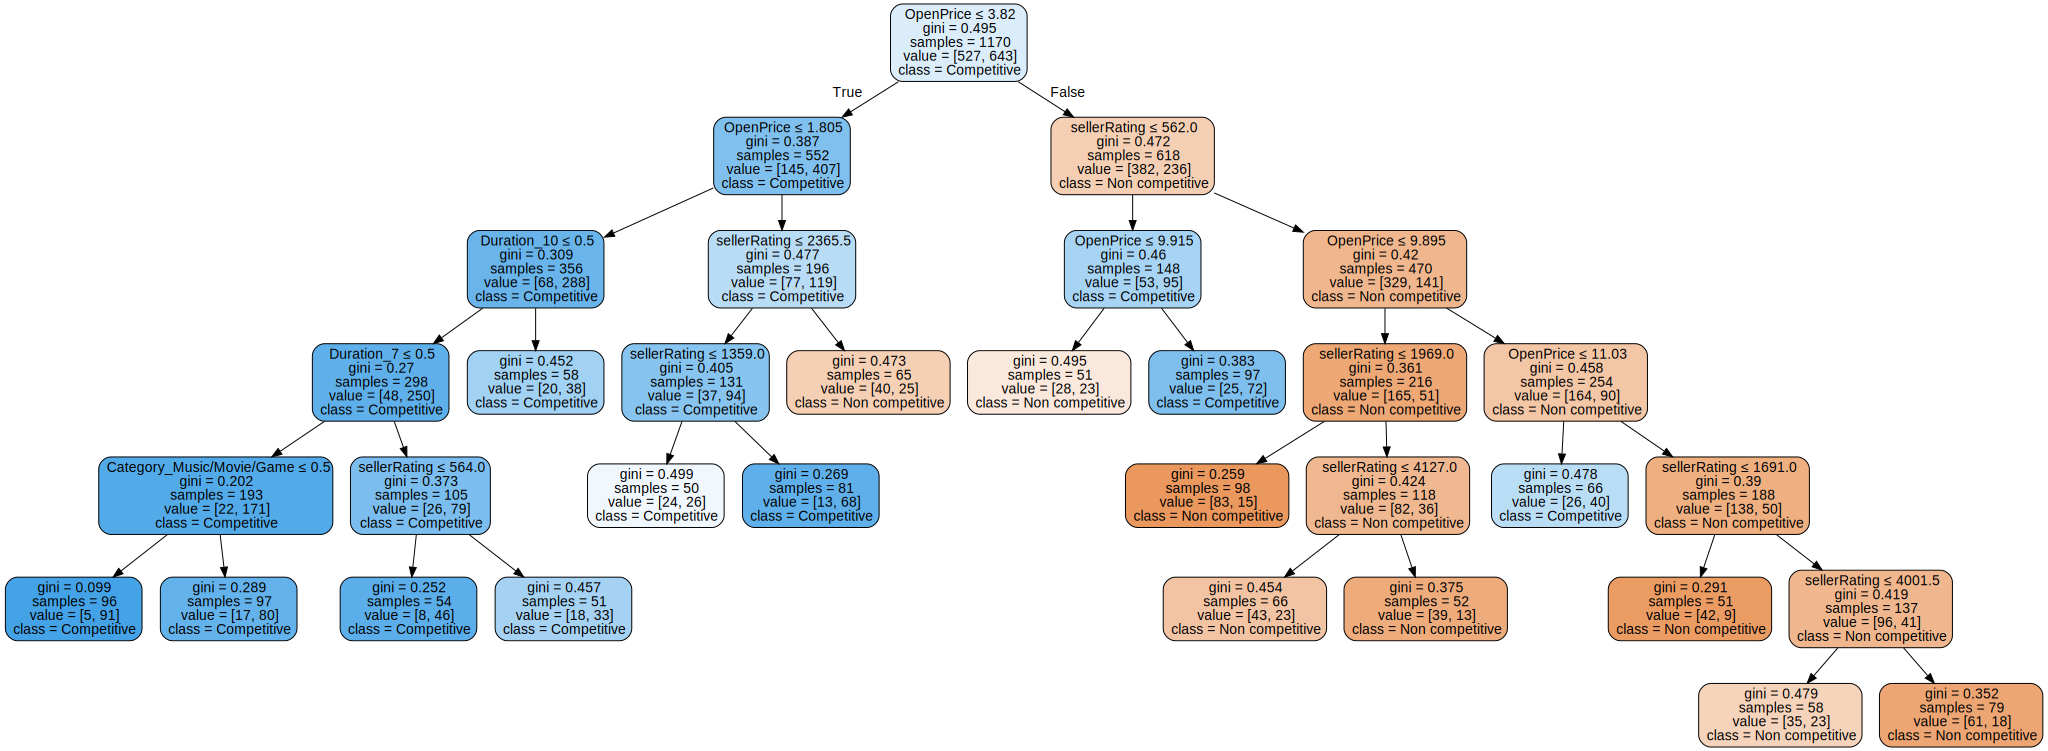

In [45]:
dot_data = export_graphviz(predClassTree, 
                  feature_names=df[final_columns].drop("Competitive?", axis = 1).columns.tolist(),  
                  class_names=["Non competitive", "Competitive"],  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph

# 8) Plot the resulting tree on a scatter plot: Use the two axes for the two best (quantitative) predictors. Each auction will appear as a point, with coordinates corresponding to its values on those two predictors. Use different colors or symbols to separate competitive and non-competitive auctions. Draw lines (you can sketch these by hand) at the values that create splits.  

<AxesSubplot:xlabel='Competitive?', ylabel='OpenPrice'>

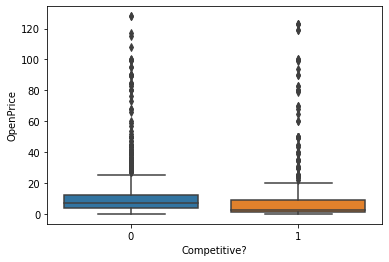

In [46]:
sns.boxplot(data=df, x='Competitive?', y='OpenPrice')

<AxesSubplot:xlabel='Competitive?', ylabel='sellerRating'>

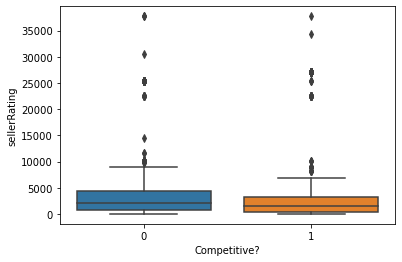

In [47]:
sns.boxplot(data=df, x='Competitive?', y='sellerRating')

<AxesSubplot:xlabel='OpenPrice', ylabel='sellerRating'>

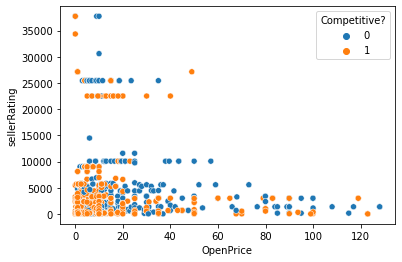

In [48]:
sns.scatterplot(x = df["OpenPrice"], y = df["sellerRating"], hue = df["Competitive?"])

# 9) Does this splitting seem reasonable with respect to the meaning of the two predictors? Does it seem to do a good job of separating the two classes? 

The splitting suggests that lower priced auctions from lower related sellers are more likely to be competitive. It sounds reasonable for the OpenPrice variable. Auctions with a lower opening price may be motivating people to bid as the initial bidding prices will be low. Also, as a result, there is still room to continue bidding and this can incentivate more bidders to compete. On the other hand, if the price is too high and there is less room to continue bidding, not many buyers may find the auction atractive. 

Regarding the seller rating, the interpretation is not at all clear as there is some ambiguity related to the cosntruction of the index. 

Also, from the graphical analysis, we can see that when using only these two features it will be difficult to generate pure nodes. 

# 10) Examine the classification table for the tree. What can you say about the predictive performance of this model? 

In [49]:
classificationSummary(y_train, predClassTree.predict(X_train))

Confusion Matrix (Accuracy 0.7393)

       Prediction
Actual   0   1
     0 371 156
     1 149 494


In [50]:
classificationSummary(y_test, predClassTree.predict(X_test))

Confusion Matrix (Accuracy 0.7157)

       Prediction
Actual   0   1
     0 263 104
     1 118 296


Normalized confusion matrix
[[0.7  0.3 ]
 [0.23 0.77]]


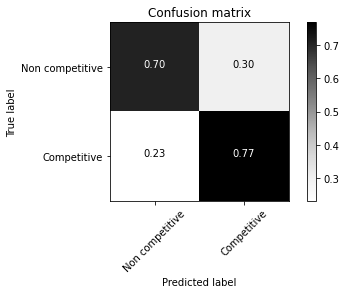

In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, predClassTree.predict(X_train))
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plot_confusion_matrix_2(cnf_matrix, normalize=True)

Normalized confusion matrix
[[0.72 0.28]
 [0.29 0.71]]


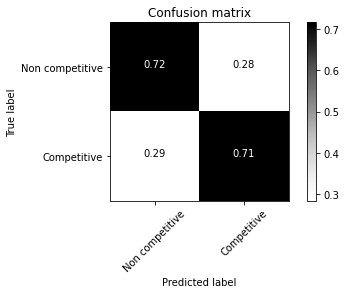

In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predClassTree.predict(X_test))
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plot_confusion_matrix_2(cnf_matrix, normalize=True)

# 11) Based on this last tree, what can you conclude from these data about the chances of an auction obtaining at least two bids and its relationship to the auction settings set by the seller (duration, opening price, ending day, currency)?  

Auctions with a low opening price, short durations and from lower rated sellers are more likely to be competitive. 
Not much to say about ending day and currency.

# 12) What would you recommend for a seller as the strategy that will most likely lead to a competitive auction? 

Auctions with a low opening price, short durations and from lower rated sellers are more likely to be competitive. 